In [1]:
import os
import re
import glob
import numpy as np
import xarray as xr

xr.set_options(display_expand_data=False)

%config InlineBackend.figure_format='retina'

In [2]:
#TSIDs:
TSIDs = ['BESI', 'GREGOR', 'HOP', 'JIL', 'NICHTJIL', 'SOM', 
         'TEST-HOP', 'TEST-HOP-mgn', 'TEST-SOM-mgn', 'TEST-VST',
         'TS021', 'TS025', 'TS027', 'TS028', 'TS029', 'VST']

#Data File Path:
file_path = os.path.join(glob.glob('C:\\Users\\mvomstein\\projects\\vt-2pod')[0], 'DATA')

file_path_save = glob.glob(
    'C:\\Users\\mvomstein\\projects\\vt_2pod_data_analysis\\DATA_xr')[0]

In [3]:
def getMatch(param, fpts, bs, hv):
    matches = [match for match in os.listdir(fpts) 
           if bs in match 
           and hv in match 
           and param in match
           and os.path.splitext(match)[1] == '.npy'
          ]
    #print(matches)
    if len(matches) >=2: raise Exception(f'MULTIPLE ENTRIES IN {TSID}: DATA NOT CLEAN', matches)
    return(matches)

In [4]:
BSs = ['forearm', 'back-lower', 'back-lower-nsa', 'abdomen', 'thigh']
HVs = ['h', 'v']
bsDic = {'forearm': 0,
         'back-lower': 1,
         'back-lower-nsa': 2,
         'abdomen': 3,
         'thigh': 4}

hvDic = {'h': 0,
         'v': 1}

In [5]:
xStr = ['postmean', 'poststd', 'stim', 'resp', 'pGuess', 'pSlope', 'pThresh']
yVal = [np.arange(2.5, 61, 2.5),
        np.arange(2.5, 61, 2.5),
        np.arange(0, 50, 1),
        np.arange(0, 50, 1),
        np.linspace(0.01, 0.99, 100), #guess
        np.linspace(0.01, 10, 50), #slope
        np.linspace(0.01, 60, 31) #thresh
       ]
yStr = ['stimRange', 'stimRange', 'trial', 'trial', 'guessGrid', 'slopeGrid', 'threshGrid']

for i in range(0, len(xStr), 1):
    for TSID in TSIDs:
        fpTS = os.path.join(file_path, TSID)
        arr = np.random.normal(size=(len(yVal[i]),1,5,2))*np.nan
        for BS in BSs:
            for HV in HVs:
                matches = getMatch('_'+xStr[i]+'_', fpTS, '_'+BS+'_', '_'+HV+'_')
                if matches:
                    x = re.split("_", matches[0])
                    singleData =np.load(
                        os.path.join(fpTS, matches[0]), allow_pickle=True)
                    arr[:len(singleData),0, bsDic[x[1]], hvDic[x[2]]] = singleData

                    #x[0]: TSID, x[1]: bs, x[2]: hv

        da = xr.DataArray(
            arr,
            dims=[yStr[i], 'tsid', 'bs', 'hv'],
            coords={yStr[i]:yVal[i],
                    'tsid':[TSID], 'bs':BSs, 'hv':['h', 'v']},
            name=xStr[i]
        )
        da.to_netcdf(os.path.join(file_path_save, xStr[i], xStr[i]+TSID+'.nc'))

In [6]:
# eParams
# =============================================================================

yStr = ['eGuess', 'eLapse', 'eSlope', 'eThreshold', 
        'stdGuess', 'stdLapse', 'stdSlope', 'stdThreshold']

for TSID in TSIDs:
    fpTS = os.path.join(file_path, TSID)
    arr = np.random.normal(size=(8,1,5,2))*np.nan
    for BS in BSs:
        for HV in HVs:
            for i in range(0, len(yStr)):
                matches = getMatch('_'+yStr[i]+'_', fpTS, '_'+BS+'_', '_'+HV+'_')
                if matches:
                    x = re.split("_", matches[0])
                    singleData =np.load(
                        os.path.join(fpTS, matches[0]), allow_pickle=True)
                    arr[i ,0, bsDic[x[1]], hvDic[x[2]]] = singleData

                #x[0]: TSID, x[1]: bs, x[2]: hv

    da = xr.DataArray(
        arr,
        dims=['variableEP', 'tsid', 'bs', 'hv'],
        coords={'variableEP':yStr,
                'tsid':[TSID], 'bs':BSs, 'hv':['h', 'v']},
        name='eParams'
    )
    da.to_netcdf(os.path.join(file_path_save, 'eParams', 'eParams'+TSID+'.nc'))

In [7]:
ds = xr.open_mfdataset(os.path.join(file_path_save, 'postmean', '*.nc'))
ds

<xarray.Dataset>
Dimensions:    (stimRange: 24, tsid: 16, bs: 5, hv: 2)
Coordinates:
  * stimRange  (stimRange) float64 2.5 5.0 7.5 10.0 12.5 ... 52.5 55.0 57.5 60.0
  * bs         (bs) object 'forearm' 'back-lower' ... 'abdomen' 'thigh'
  * hv         (hv) object 'h' 'v'
  * tsid       (tsid) object 'BESI' 'GREGOR' 'HOP' ... 'TS028' 'TS029' 'VST'
Data variables:
    postmean   (stimRange, tsid, bs, hv) float64 dask.array<chunksize=(24, 1, 5, 2), meta=np.ndarray>

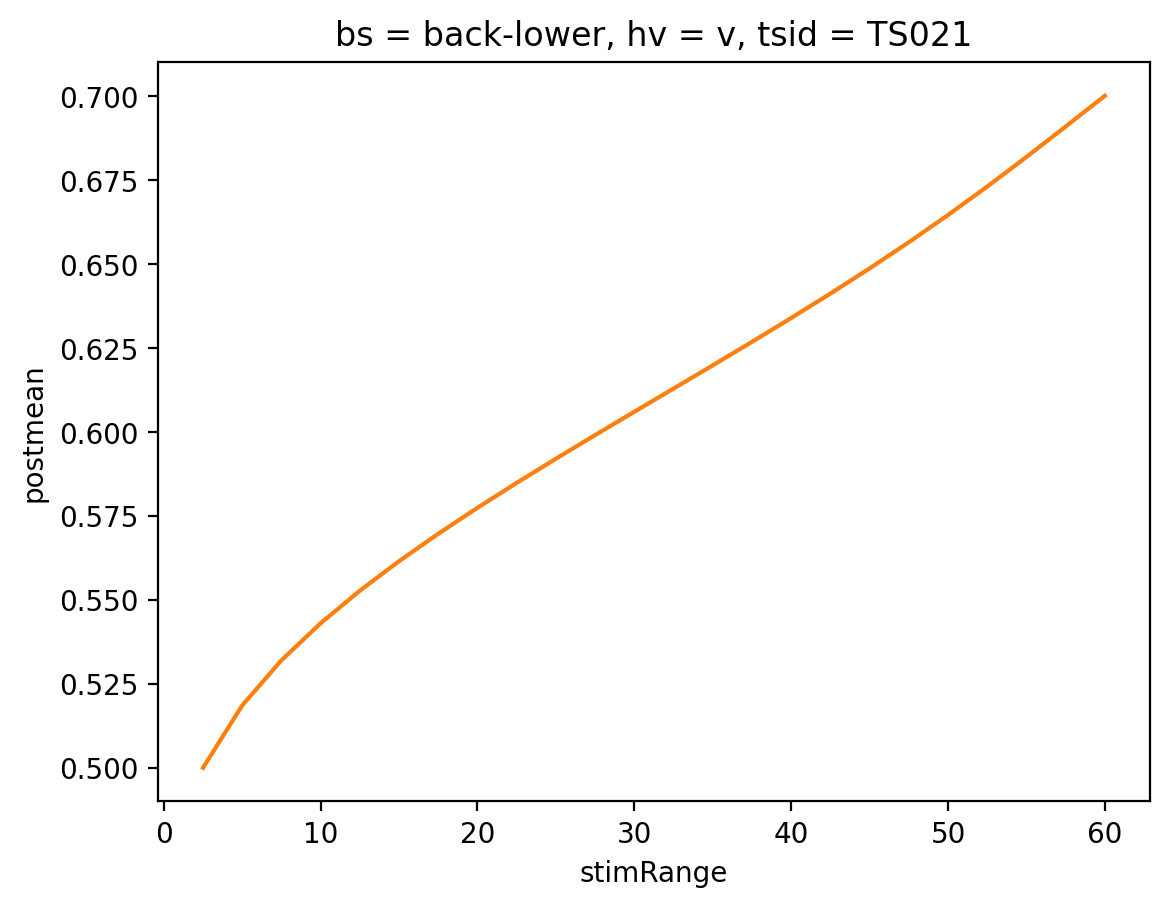

In [8]:
ds.postmean.sel(tsid='TS021',bs='back-lower', hv='h').plot()
ds.postmean.sel(tsid='TS021',bs='back-lower', hv='v').plot()

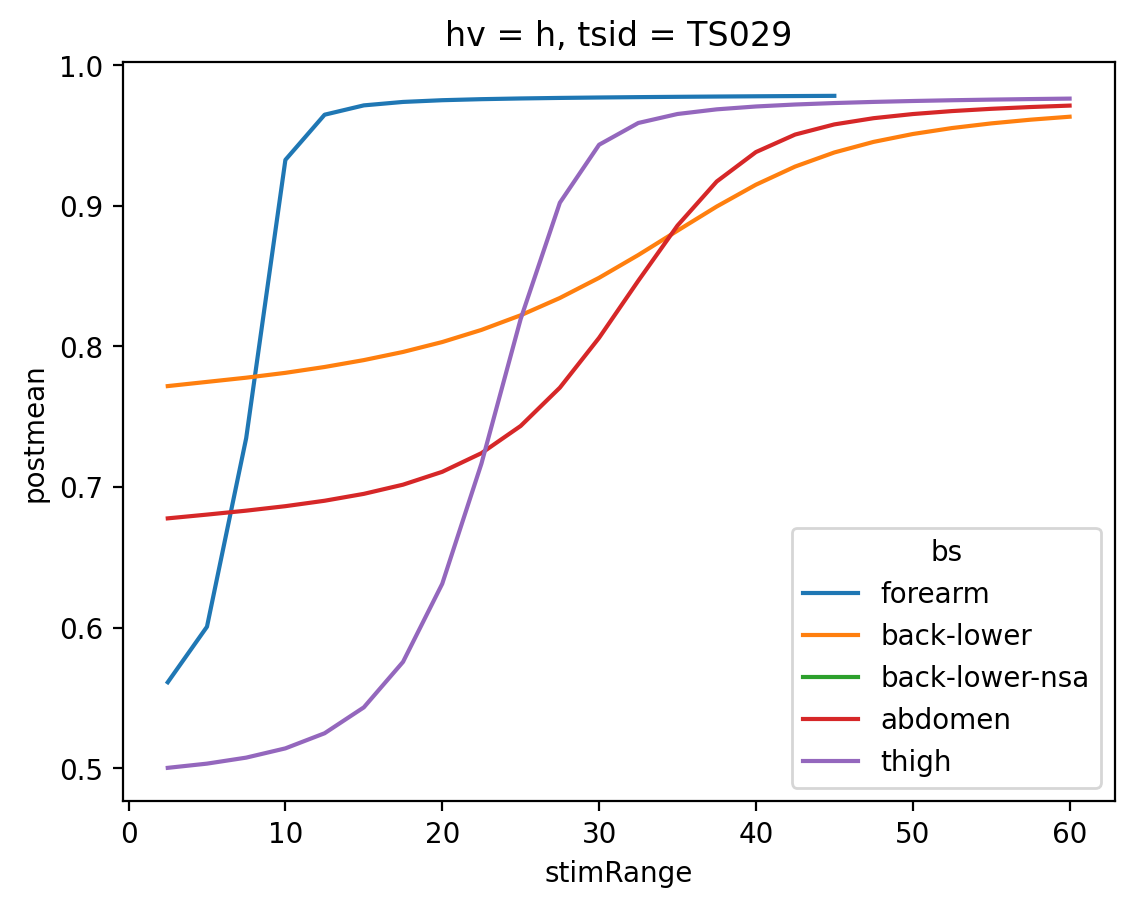

In [9]:
ds.postmean.sel(tsid='TS029', bs=BSs, hv='h').plot.line(x='stimRange');

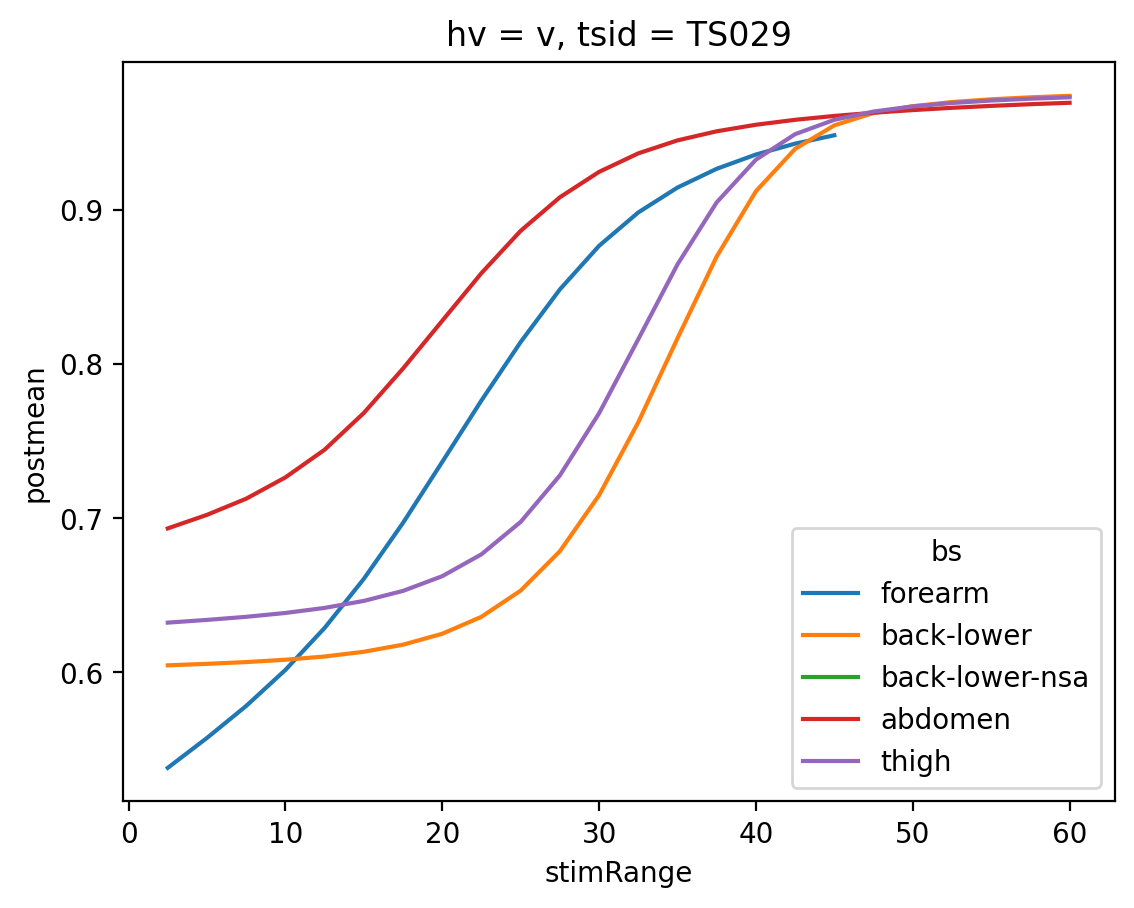

In [10]:
ds.postmean.sel(tsid='TS029', bs=BSs, hv='v').plot.line(x='stimRange');

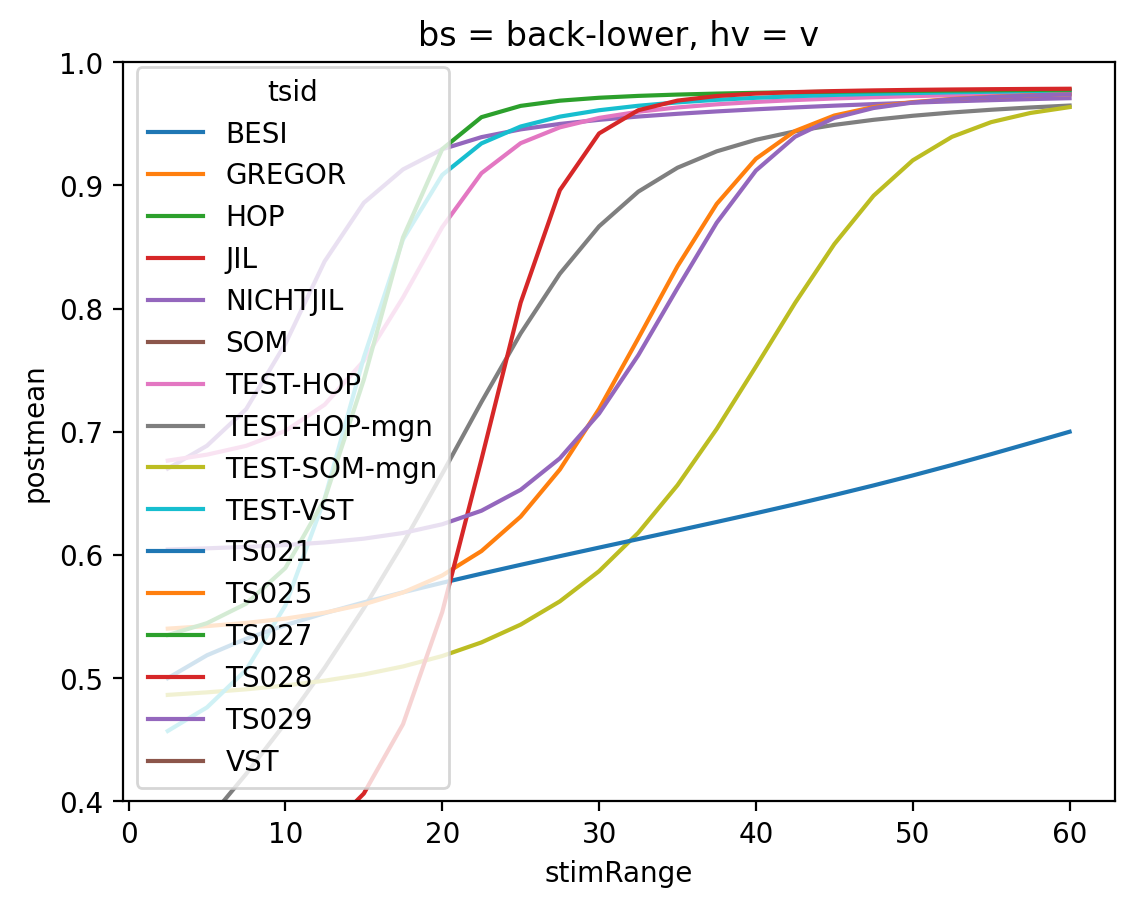

In [11]:
ds.postmean.sel(tsid=TSIDs, bs='back-lower', hv='v').plot.line(x='stimRange', ylim=[0.4,1]);

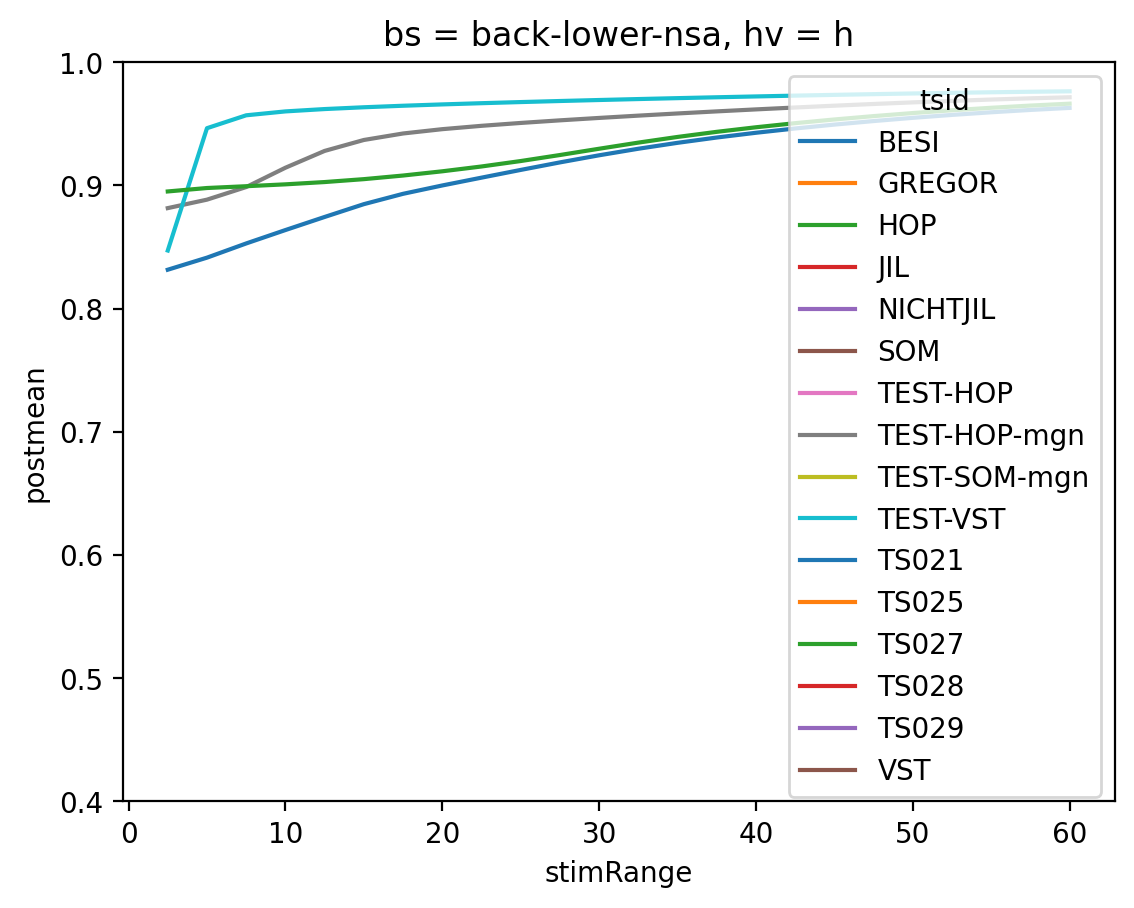

In [12]:
ds.postmean.sel(tsid=TSIDs, bs='back-lower-nsa', hv='h').plot.line(x='stimRange',ylim=[0.4,1]);

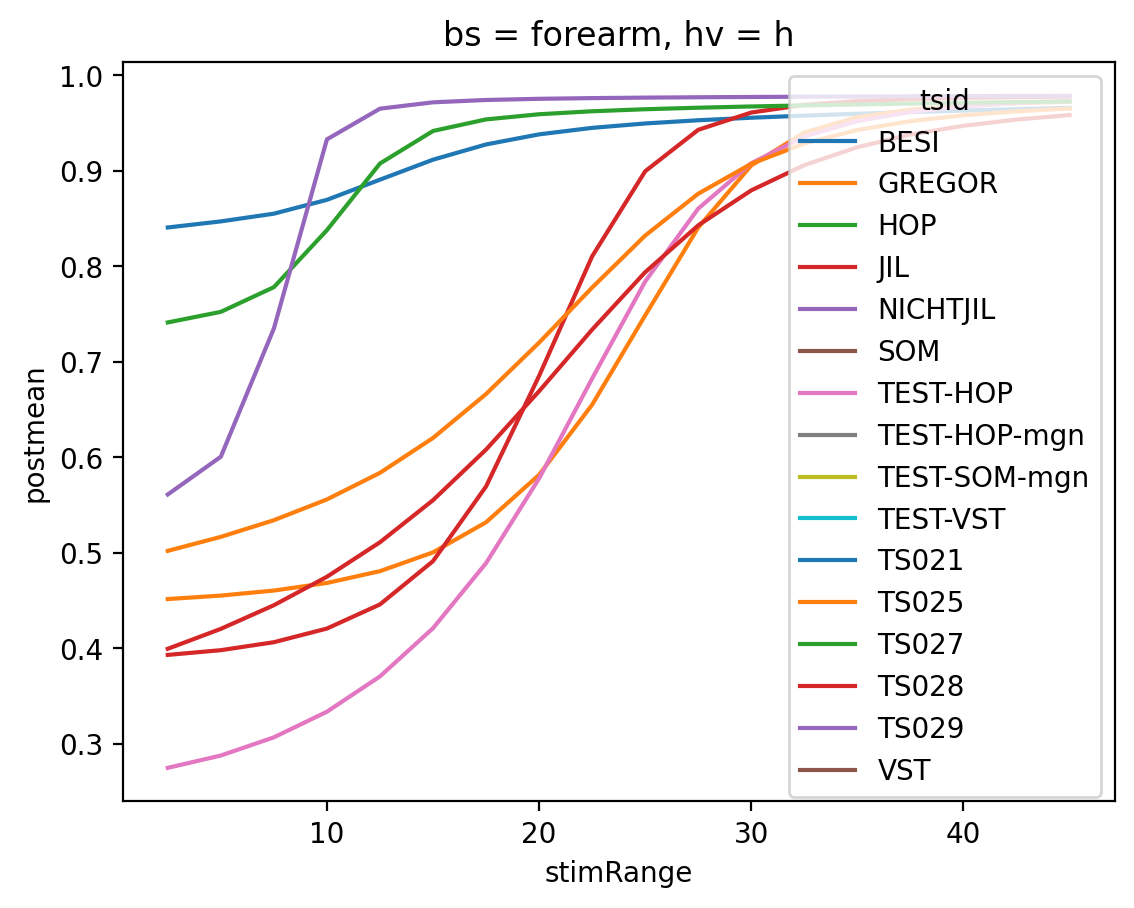

In [13]:
 ds.postmean.sel(tsid=TSIDs,bs='forearm', hv='h').plot.line(x='stimRange');

C:\Users\mvomstein\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


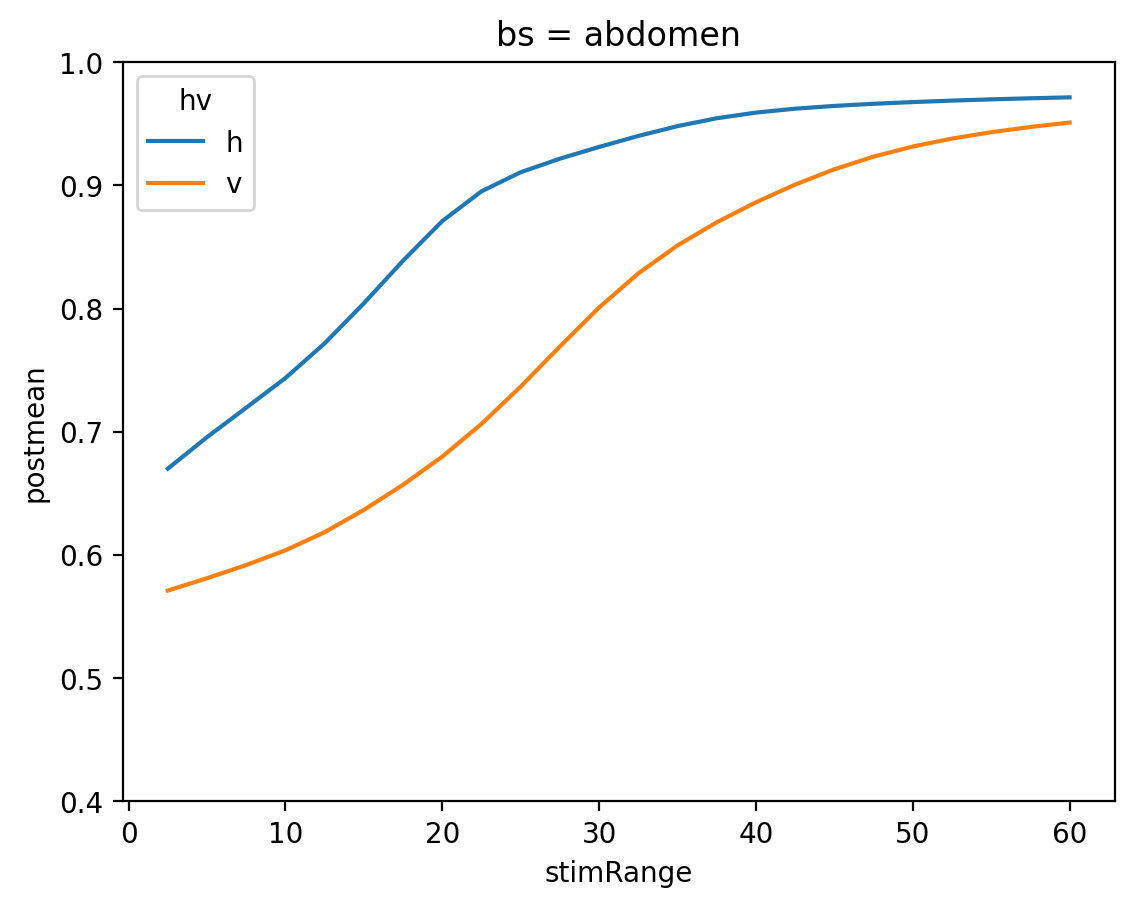

In [14]:
ds.postmean.mean(dim='tsid').sel(bs='abdomen', hv=['h','v']).plot.line(x='stimRange',ylim=[0.4,1]);

C:\Users\mvomstein\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


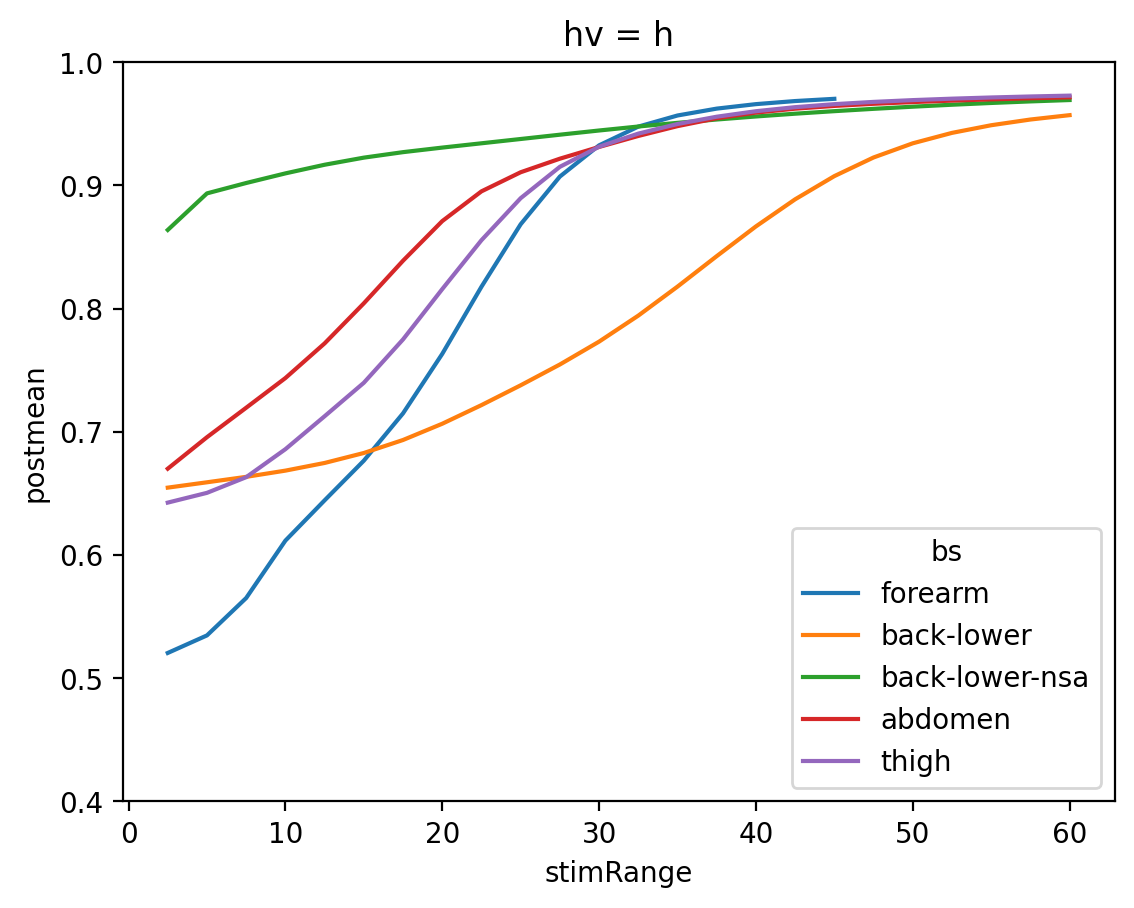

In [15]:
ds.postmean.mean(dim='tsid').sel(bs=BSs, hv='h').plot.line(x='stimRange',ylim=[0.4,1]);

C:\Users\mvomstein\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


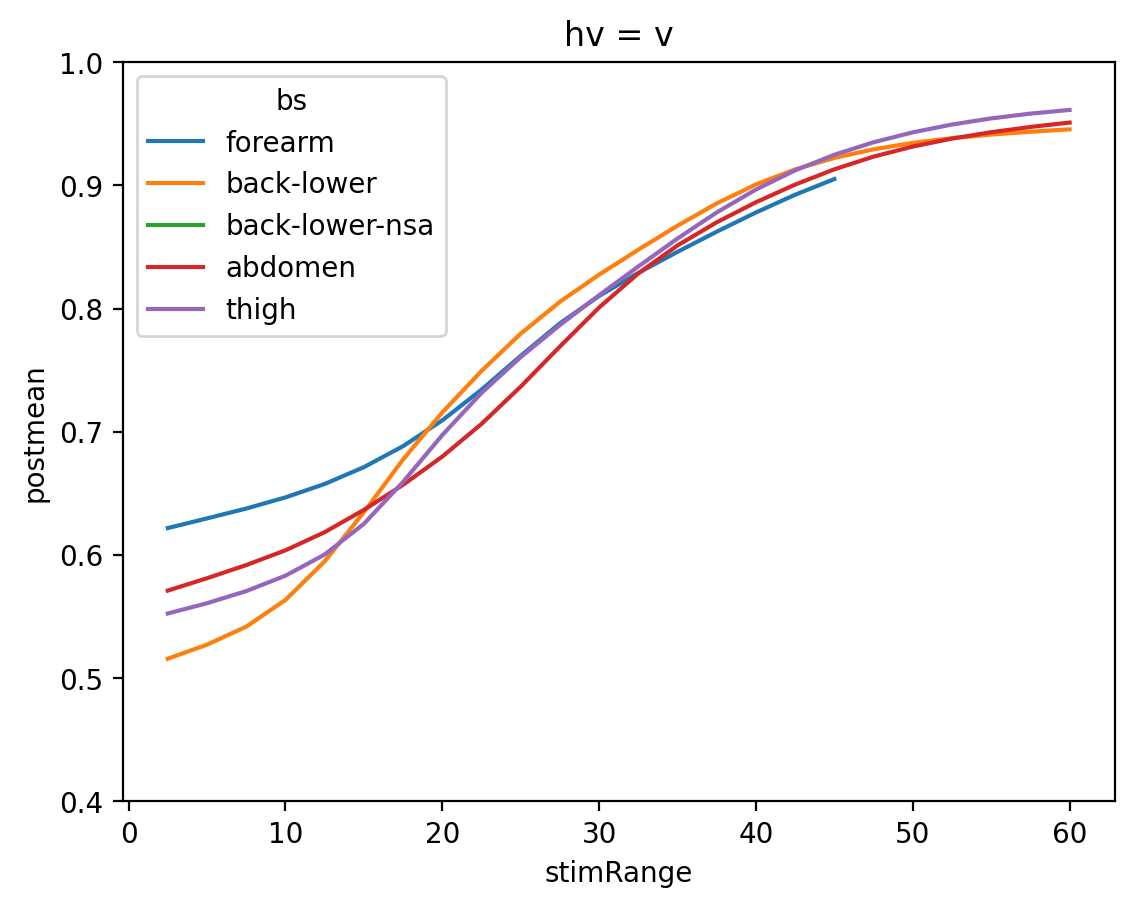

In [20]:
ds.postmean.mean(dim='tsid', skipna=True).sel(bs=BSs, hv='v').plot.line(x='stimRange',ylim=[0.4,1]);

C:\Users\mvomstein\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


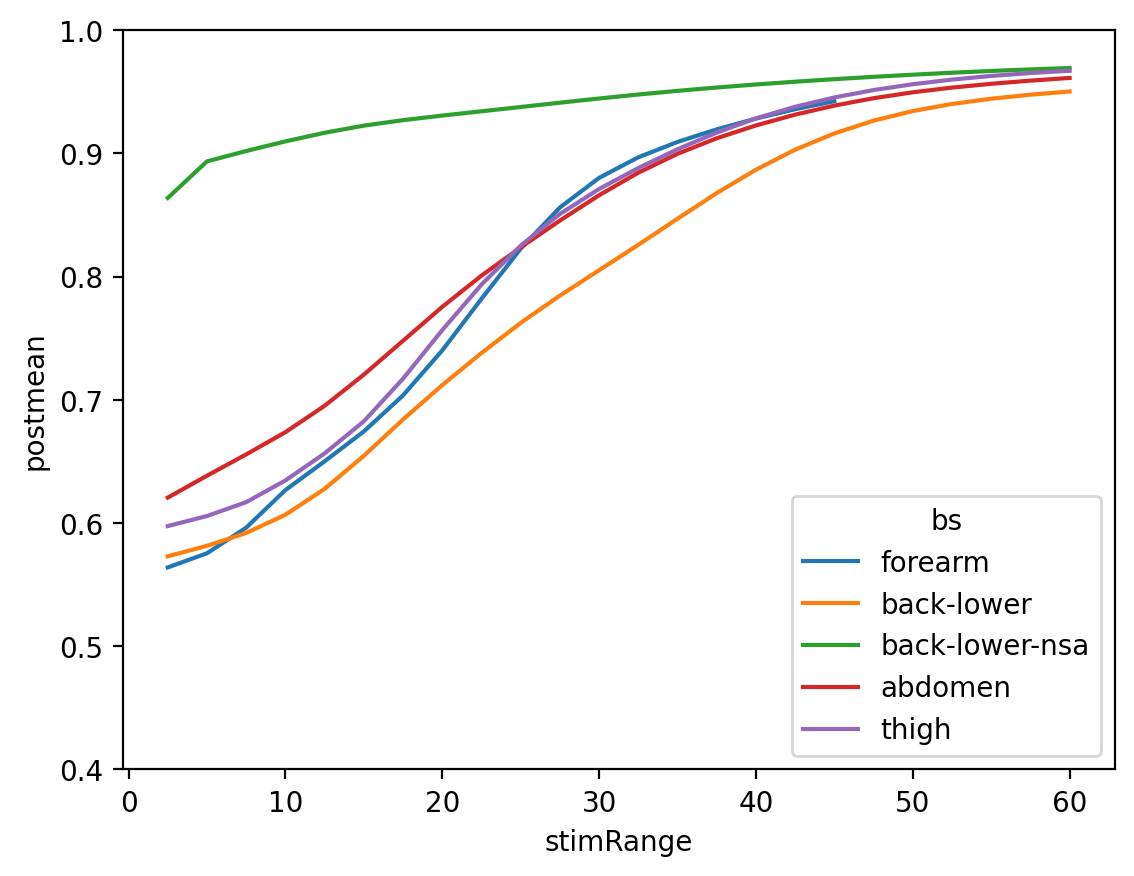

In [17]:
ds.postmean.mean(dim=['tsid','hv']).sel(bs=BSs).plot.line(x='stimRange',ylim=[0.4,1]);

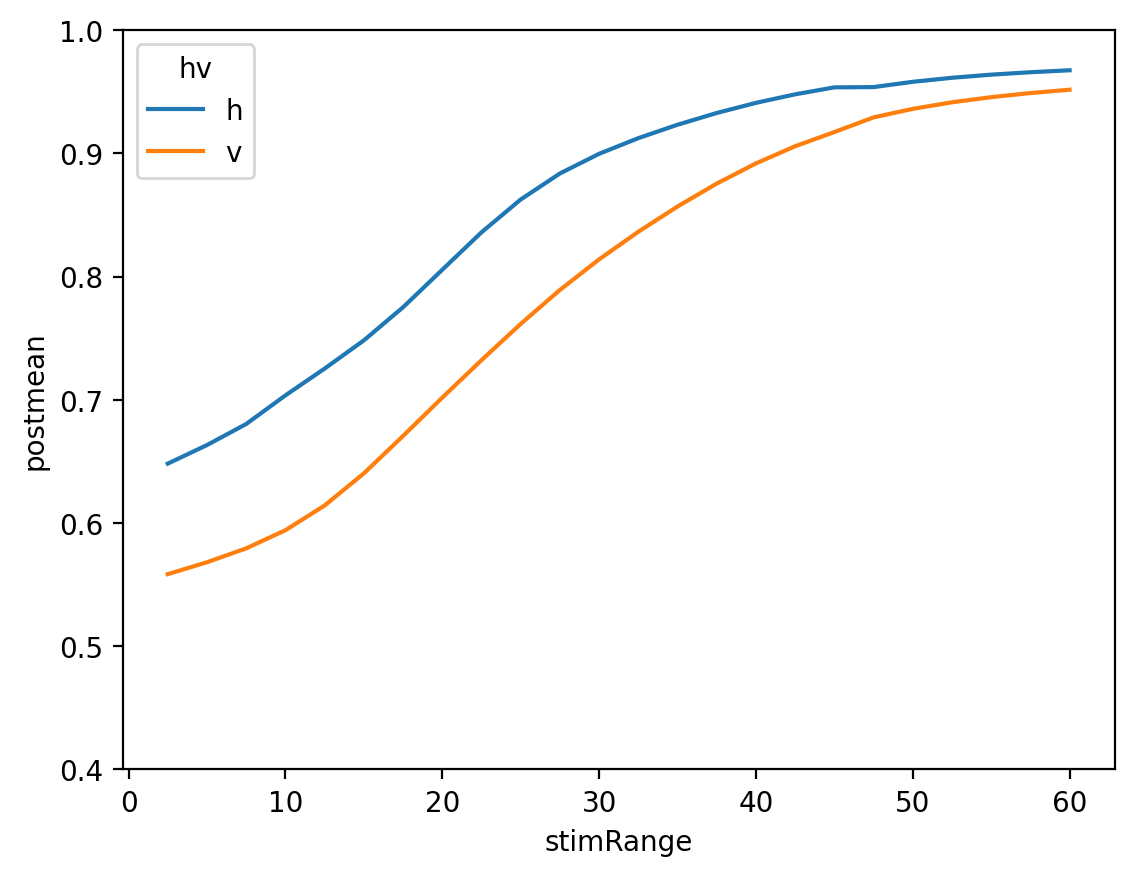

In [18]:
ds.postmean.mean(dim=['tsid','bs']).sel(hv=HVs).plot.line(x='stimRange',ylim=[0.4,1]);

In [19]:
#ds = xr.open_mfdataset(os.path.join(file_path_save, 'eParams', '*.nc'))
#ds.eParams.sel(tsid='TS021', bs='thigh', hv='h', variableEP='eGuess').values